# Riesgo por incumplimiento de pagos en créditos de vivienda
---------------------------------------------------------------------------------------------------------------------------

**Autor:** Cristhian David Tafur Hernández

**Asesor:** Raul Ramos


Notebook: 02 Gestión de datos desbalanceados y selección de estrategia

Objetivo de la Iteración:

En la presente iteración se busca probar las diferentes estrategias de remuestreo o asignación de pesos a las muestras para tratar el problema de datos desbalanceados. Para la evaluación de dichas estrategias se recurre a estimar las métricas de validación de un modelo estándar de regresión logística y uno de bosques aleatorios de clasificación

## Preparación de entorno de trabajo

In [ ]:
pip install -U imbalanced-learn

     |████████████████████████████████| 199 kB 4.8 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
# Básicas
# ==============================================================================
import pandas as pd
import numpy as np

# Preporcesamiento de datos
# ==============================================================================
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, plot_confusion_matrix
 
from pylab import rcParams
 
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter

# Elección de hiperparametros
# ==============================================================================
from sklearn.model_selection import GridSearchCV


# Modelamiento
# ==============================================================================
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier


# Graficación
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta_lectura ='/content/drive/MyDrive/Monografia/data_modelo/'

## 00. Preparación de los datos (procesamiento y guardado)

In [ ]:
#Carga de tabla principal
# d = pd.read_csv ('application_train.csv')
d = pd.read_csv (ruta_lectura + 'application_train.csv')
#Se asigna el "ID" como index
d.set_index('SK_ID_CURR', inplace=True)
d.shape

(307511, 121)

In [ ]:
#Tipos de variables.
# archivo auxiliar construido para el entendimiento de las features
# ==============================================================================
# det_var = pd.read_excel('type_variables.xlsx')
det_var = pd.read_excel(ruta_lectura + 'type_variables.xlsx')
det_app = det_var[det_var['Table']=='application_{train|test}.csv']

# Se separa la data en distintos sets: 
#la variable objetivo y las Features de acuerdo a la necesidad de procesamiento

# set TARGET
# ==============================================================================
d_y = d['TARGET']

# set Features numericas
# ==============================================================================
det_app_N = det_app[(det_app['type']=='N')]
var_n = det_app_N['column'].tolist()
d_xn = d[var_n]

# set Features categoricas
# ==============================================================================
det_app_C = det_app[(det_app['type']=='C')]
var_c = det_app_C['column'].tolist()
d_xc = d[var_c]

### Variables numericas
Para esta primera iteración a las Features numéricas tan solo se le aplica un proceso de imputación de valores faltantes usando la mediana de cada una de ellas. No se aplican procesos de limpieza de datos atípicos o de transformación de variables.

In [ ]:
# Imputación de valores faltantes con la mediana
d_xn.fillna(d_xn.median(), inplace =True)

### Variables categóricas
Para esta primera iteración se aplica un proceso de transformación a las Features categóricas conocido como One-Hot Encoder. Algunas variables ya vienen en esa estructura desde la data original, por ello el set de categóricas de divide en dos sub-sets. 

In [ ]:
col_str = (d_xc.dtypes == object)
col_str = [c for c in col_str.index if col_str[c]]

col_du = (d_xc.dtypes != object)
col_du = [c for c in col_du.index if col_du[c]]

In [ ]:
d_xc_str = pd.get_dummies(d_xc[col_str], prefix=col_str)

In [ ]:
d_xc_du = d_xc[col_du]

In [ ]:
# Validación de que las variables transformadas no contengan valores faltantes
d_xc_str.isnull().sum().sum(), d_xc_du.isnull().sum().sum(), d_xn.isnull().sum().sum()

(0, 0, 0)

### Datos para la implementacipon de los modelos 

Trin/ test data

In [ ]:
# Estructuración de la información para la implementación del modelo
d_x = pd.merge(d_xn, d_xc_du, how ='inner', left_index=True, right_index=True)
d_x = pd.merge(d_x, d_xc_str, how ='inner', left_index=True, right_index=True)

In [ ]:
# Guardando el nombre de las features 
feature_name = d_x.columns.tolist()
pd.DataFrame(feature_name).to_csv(ruta_lectura + "feature_names.csv", index = False)

In [ ]:
# Reescalamiento de datos
d_x_scaled = MinMaxScaler().fit_transform(d_x)

In [ ]:
# Función para evaluar la distribución de clases de una variable
def dis_clases(var):
  a1 = pd.DataFrame(pd.value_counts(var, normalize=True)).round(4).rename(columns = {var.name:'%'})
  a2 = pd.DataFrame(pd.value_counts(var)).rename(columns = {var.name:'Muestras'})
  a = pd.merge(a2, a1, how='inner', left_index=True, right_index=True)

  return a

In [ ]:
#División de la data en sets de Test y entrenamiento aplicando estratificación
# 20% Test y 80% Entrenamiento

# División estratificada
print('Distribución del target: Data train estratificada')

X_train, X_test, y_train, y_test = train_test_split(d_x_scaled, d_y, 
                                                    test_size=0.2, random_state=0, stratify=d_y)

print(dis_clases(y_train))
print('------------------------------------------------------------------------')
print(f'X_train: {X_train.shape}, X_test: {X_test.shape} ')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape} ')

np.savetxt(ruta_lectura + "X_train.csv", X_train, delimiter=",")
np.savetxt(ruta_lectura + "y_train.csv", y_train, delimiter=",")

np.savetxt(ruta_lectura + "X_test.csv", X_test, delimiter=",")
np.savetxt(ruta_lectura + "y_test.csv", y_test, delimiter=",")

Distribución del target: Data train estratificada
   Muestras       %
0    226148  0.9193
1     19860  0.0807
------------------------------------------------------------------------
X_train: (246008, 244), X_test: (61503, 244) 
y_train: (246008,), y_test: (61503,) 


### Aplicación de técncas de remuestreo

In [ ]:
# División con Subsampling en la clase mayoritaria
print('Distribución del target: Subsampling en la clase mayoritaria')

us = NearMiss()
X_train_us, y_train_us = us.fit_resample(X_train, y_train)

print(dis_clases(y_train_us))
print('------------------------------------------------------------------------')
print(f'X_train_us: {X_train_us.shape}')
print(f'y_train_us: {y_train_us.shape} ')

np.savetxt(ruta_lectura + "X_train_us.csv", X_train_us, delimiter=",")
np.savetxt(ruta_lectura + "y_train_us.csv", y_train_us, delimiter=",")

Distribución del target: Subsampling en la clase mayoritaria
     Muestras    %
0.0     19860  0.5
1.0     19860  0.5
------------------------------------------------------------------------
X_train_us: (39720, 244)
y_train_us: (39720,) 


In [ ]:
# División con Oversampling de la clase minoritaria
print('Distribución del target: Oversampling de la clase minoritaria')

os =  RandomOverSampler()
X_train_os, y_train_os = os.fit_resample(X_train, y_train)

print(dis_clases(y_train_os))
print('------------------------------------------------------------------------')
print(f'X_train_os: {X_train_os.shape}')
print(f'y_train_os: {y_train_os.shape} ')

np.savetxt(ruta_lectura + "X_train_os.csv", X_train_os, delimiter=",")
np.savetxt(ruta_lectura + "y_train_os.csv", y_train_os, delimiter=",")

Distribución del target: Oversampling de la clase minoritaria
     Muestras    %
0.0    226148  0.5
1.0    226148  0.5
------------------------------------------------------------------------
X_train_os: (452296, 244)
y_train_os: (452296,) 


In [ ]:
# División Combinando el resampling con Smote-Tomek
print('Distribución del target: Combinando el resampling con Smote-Tomek')

os_us = SMOTETomek()
X_train_os_us, y_train_os_us = os_us.fit_resample(X_train, y_train)

print(dis_clases(y_train_os_us))
print('------------------------------------------------------------------------')
print(f'X_train_os_us: {X_train_os_us.shape}')
print(f'y_train_os_us: {y_train_os_us.shape} ')

np.savetxt(ruta_lectura + "X_train_os_us.csv", X_train_os_us, delimiter=",")
np.savetxt(ruta_lectura + "y_train_os_us.csv", y_train_os_us, delimiter=",")

Distribución del target: Combinando el resampling con Smote-Tomek
   Muestras    %
0    226141  0.5
1    226141  0.5
------------------------------------------------------------------------
X_train_os_us: (452282, 244)
y_train_os_us: (452282,) 


## 00. Lectura de datos procesados para los modelos

In [ ]:
# Función para evaluar la distribución de clases de una variable
def dis_clases(var):
  a1 = pd.DataFrame(pd.value_counts(var, normalize=True)).round(4).rename(columns = {0:'%'})
  a2 = pd.DataFrame(pd.value_counts(var)).rename(columns = {0:'Muestras'})
  a = pd.merge(a2, a1, how='inner', left_index=True, right_index=True)

  return a

In [ ]:
# División estratificada
print('Distribución del target: Data train estratificada')

X_train = pd.read_csv (ruta_lectura+ 'X_train.csv', header=None)
y_train = pd.read_csv (ruta_lectura+ 'y_train.csv', header=None)
X_train = np.array(X_train)
y_train = np.array(y_train).reshape((-1))


X_test = pd.read_csv (ruta_lectura+ 'X_test.csv', header=None)
y_test = pd.read_csv (ruta_lectura+ 'y_test.csv', header=None)
X_test = np.array(X_test)
y_test = np.array(y_test).reshape((-1))

print(dis_clases(y_train))
print('------------------------------------------------------------------------')
print(f'X_train: {X_train.shape}, X_test: {X_test.shape} ')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape} ')

Distribución del target: Data train estratificada
     Muestras       %
0.0    226148  0.9193
1.0     19860  0.0807
------------------------------------------------------------------------
X_train: (246008, 244), X_test: (61503, 244) 
y_train: (246008,), y_test: (61503,) 


In [ ]:
# División con Subsampling en la clase mayoritaria
print('Distribución del target: Subsampling en la clase mayoritaria')

X_train_us = pd.read_csv (ruta_lectura + 'X_train_us.csv', header=None)
y_train_us = pd.read_csv (ruta_lectura + 'y_train_us.csv', header=None)
X_train_us = np.array(X_train_us)
y_train_us = np.array(y_train_us).reshape((-1))

print(dis_clases(y_train_us))
print('------------------------------------------------------------------------')
print(f'X_train_us: {X_train_us.shape}')
print(f'y_train_us: {y_train_us.shape} ')

Distribución del target: Subsampling en la clase mayoritaria
     Muestras    %
0.0     19860  0.5
1.0     19860  0.5
------------------------------------------------------------------------
X_train_us: (39720, 244)
y_train_us: (39720,) 


In [ ]:
# División con Oversampling de la clase minoritaria
print('Distribución del target: Oversampling de la clase minoritaria')

X_train_os = pd.read_csv (ruta_lectura + 'X_train_os.csv', header=None)
y_train_os = pd.read_csv (ruta_lectura + 'y_train_os.csv', header=None)
X_train_os = np.array(X_train_os)
y_train_os = np.array(y_train_os).reshape((-1))

print(dis_clases(y_train_os))
print('------------------------------------------------------------------------')
print(f'X_train_os: {X_train_os.shape}')
print(f'y_train_os: {y_train_os.shape} ')

Distribución del target: Oversampling de la clase minoritaria
     Muestras    %
0.0    226148  0.5
1.0    226148  0.5
------------------------------------------------------------------------
X_train_os: (452296, 244)
y_train_os: (452296,) 


In [ ]:
# División Combinando el resampling con Smote-Tomek
print('Distribución del target: Combinando el resampling con Smote-Tomek')

X_train_os_us = pd.read_csv (ruta_lectura + 'X_train_os_us.csv', header=None)
y_train_os_us = pd.read_csv (ruta_lectura + 'y_train_os_us.csv', header=None)
X_train_os_us = np.array(X_train_os_us)
y_train_os_us = np.array(y_train_os_us).reshape((-1))

print(dis_clases(y_train_os_us))
print('------------------------------------------------------------------------')
print(f'X_train_os_us: {X_train_os_us.shape}')
print(f'y_train_os_us: {y_train_os_us.shape} ')

Distribución del target: Combinando el resampling con Smote-Tomek
     Muestras    %
0.0    226141  0.5
1.0    226141  0.5
------------------------------------------------------------------------
X_train_os_us: (452282, 244)
y_train_os_us: (452282,) 


## 01. Evaluación sobre modelos de clasificación

Se usan los algoritmos de regresión logística y bosques aleatorios de clasificación para evaluar las diferente alternativas de remuestreo. Adicionalmente, también se prueba el control que ejerce el hiperparámetro que traen los algoritmos para datos desbalanceados.  

In [ ]:
#definimos funciona para mostrar los resultados

def mostrar_resultados(y_test, x_test, model_fit, normalize = None):
    pred_y = model_fit.predict(x_test)
    disp = plot_confusion_matrix(model_fit, x_test, y_test,
                             cmap=plt.cm.Blues, 
                             normalize=normalize)
    
    disp.ax_.set_title('MC normalizada')
    plt.show()
    print ('--------------------------------------------------------------------')
    print (classification_report(y_test, pred_y))

### A. Regresión logística

In [ ]:
# Modelo de LogisticRegresion básico (Sin hiperparametro para balancear )
def run_logit(X_train, y_train):
    logit = LogisticRegression()
    logit.fit(X_train, y_train)
    return logit

# Modelo de LogisticRegresion incluyendo parametro para el desbalance
def run_logit_balanced(X_train, y_train):
    logit_b = LogisticRegression(class_weight="balanced")
    logit_b.fit(X_train, y_train)
    return logit_b

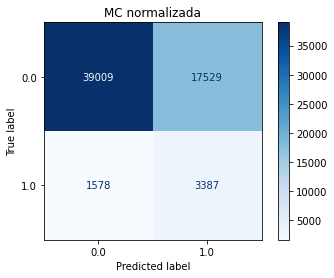

--------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56538
         1.0       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503



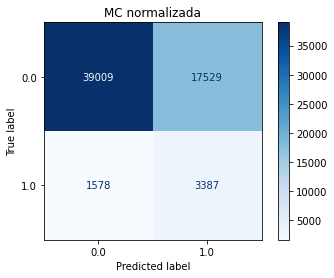

--------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56538
         1.0       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503



In [ ]:
# Modelo logit 1.1: Logit controlando el desbalance con el hiperparametro del algoritmo de clasificación
logit_1_1 = run_logit_balanced(X_train, y_train)
mostrar_resultados(y_test, X_test, logit_1_1)
mostrar_resultados(y_test, X_test, logit_1_1, normalize = None)

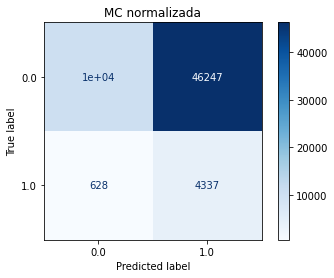

--------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.18      0.31     56538
         1.0       0.09      0.87      0.16      4965

    accuracy                           0.24     61503
   macro avg       0.51      0.53      0.23     61503
weighted avg       0.87      0.24      0.29     61503



In [ ]:
# Modelo logit 1.2: Logit controlando el desbalance desde el muestreo train con subsampling
logit_1_2 = run_logit(X_train_us, y_train_us)
mostrar_resultados(y_test, X_test, logit_1_2)

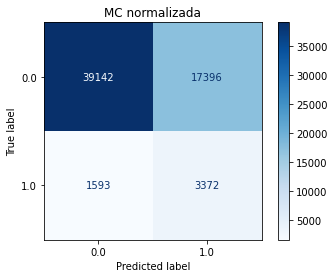

--------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56538
         1.0       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503



In [ ]:
# Modelo logit 1.3: Logit controlando el desbalance desde el muestreo train con oversampling
logit_1_3 = run_logit(X_train_os, y_train_os)
mostrar_resultados(y_test, X_test, logit_1_3)

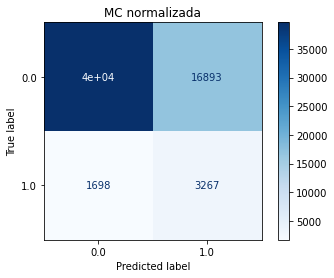

--------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56538
         1.0       0.16      0.66      0.26      4965

    accuracy                           0.70     61503
   macro avg       0.56      0.68      0.54     61503
weighted avg       0.89      0.70      0.77     61503



In [ ]:
# Modelo logit 1.4: Logit controlando el desbalance desde el muestreo train con sub - over sampling
logit_1_4 = run_logit(X_train_os_us, y_train_os_us)
mostrar_resultados(y_test, X_test, logit_1_4)

### B. Implementación del Modelo:  Random Forest
Este modelo realiza el pronóstico basado en una combinación de árboles de clasificación.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def run_rforest(X_train, y_train):
    rforest = RandomForestClassifier()
    rforest.fit(X_train, y_train)
    return rforest

# Modelo  incluyendo parametro para el desbalance
def run_rforest_balanced(X_train, y_train):
    rforest_b = RandomForestClassifier(class_weight='balanced_subsample') #class_weight = {0:1, 1:5} #peso para cada clase
    rforest_b.fit(X_train, y_train)
    return rforest_b

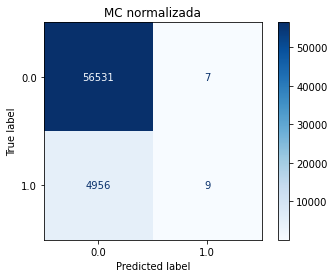

--------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.56      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.74      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503



In [ ]:
# Modelo RandomForest 1.1: RandomForest controlando el desbalance con el hiperparametro del algoritmo de clasificación
rforest_1_1 = run_rforest_balanced(X_train, y_train)
mostrar_resultados(y_test, X_test, rforest_1_1)

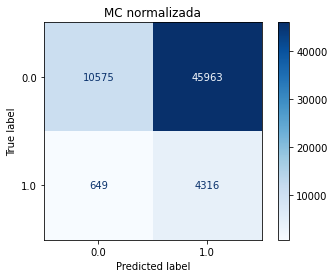

--------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.19      0.31     56538
         1.0       0.09      0.87      0.16      4965

    accuracy                           0.24     61503
   macro avg       0.51      0.53      0.23     61503
weighted avg       0.87      0.24      0.30     61503



In [ ]:
# Modelo RandomForest 1.2: RandomForest controlando el desbalance desde el muestreo train con subsampling
rforest_1_2 = run_rforest(X_train_us, y_train_us)
mostrar_resultados(y_test, X_test, rforest_1_2)

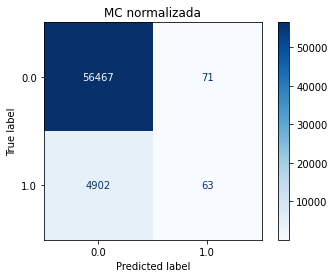

--------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.47      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.49     61503
weighted avg       0.88      0.92      0.88     61503



In [ ]:
# Modelo RandomForest 1.3: RandomForest controlando el desbalance desde el muestreo train con oversampling
rforest_1_3 = run_rforest(X_train_os, y_train_os)
mostrar_resultados(y_test, X_test, rforest_1_3)

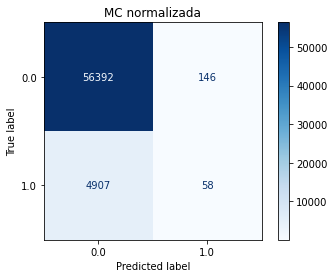

--------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.28      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.60      0.50      0.49     61503
weighted avg       0.87      0.92      0.88     61503



In [ ]:
# Modelo RandomForest 1.4: RandomForest controlando el desbalance desde el muestreo train con sub - over sampling
rforest_1_4 = run_rforest(X_train_os_us, y_train_os_us)
mostrar_resultados(y_test, X_test, rforest_1_4)

# Conclusión de la iteración:
 
Centrando la atención en los resultados de las regresiones logísticas, se observa que son la técnica de remuestreo combinada (over - subsampling), de sobremuestreo y el control por asignación de pesos los que permiten las mejores métricas de validación de los modelos. Desde el algoritmo de árboles aleatorios se observa algo similar, sin embargo, los resultados de estos algoritmos deben asumirse con mayor precaución ya que se centran solamente en predecir correctamente la clase mayoritaria.
 
De lo anterior se concluye que los hiperparámetros que tienen los algoritmos de clasificación para el control de data desbalanceada cumplen satisfactoriamente su función al compararse con las técnicas de remuestreo y por ende se usará la muestra original de datos de entrenamiento junto con el hiperparámetro de pesos para las clases.
